In [3]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

C:\Users\admin\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")
    plt.show()

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")
    plt.show()

Download some images of various animals. Load them in Python, for example using the matplotlib.image.mpimg.imread() function or the scipy.misc.imread() function. Resize and/or crop them to 299 × 299 pixels, and ensure that they have just three channels (RGB), with no transparency channel. The images that the Inception model was trained on were preprocessed so that their values range from -1.0 to 1.0, so you must ensure that your images do too.

In [28]:
width = 299
height = 299
channels = 3

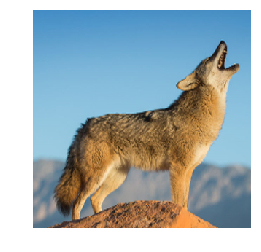

In [30]:
import matplotlib.image as mpimg
test_image = mpimg.imread("kojot.png")[:, :, :channels]
plt.imshow(test_image)
plt.axis("off")
plt.show()

Upewnij się, że wartości kolorów pikseli mieszczą się w zakresie [-1, 1]

In [31]:
test_image = 2 * test_image - 1

# Zad

Pobierz najnowszy wersję klasyfikatora Inception v3: 
  * punkt kontrolny jest dostępne pod adresem https://github.com/tensorflow/models/tree/master/research/slim. 
  * Lista nazw klas jest dostępna na stronie https://goo.gl/brXRtZ, ale musisz wstawić klasę "background" na początku.



In [16]:
import sys
import tarfile
from six.moves import urllib

TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

print(INCEPTION_V3_URL)
print(INCEPTION_PATH)
print(INCEPTION_V3_CHECKPOINT_PATH)

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
    if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "inception_v3.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    inception_tgz = tarfile.open(tgz_path)
    inception_tgz.extractall(path=path)
    inception_tgz.close()
    os.remove(tgz_path)

http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz
datasets\inception
datasets\inception\inception_v3.ckpt


In [13]:
fetch_pretrained_inception_v3()

Downloading: 100%

In [20]:
import re

CLASS_NAME_REGEX = re.compile(r"^n\d+\s+(.*)\s*$", re.M | re.U)

def load_class_names():
    with open(os.path.join(".\datasets", "inception", "imagenet_class_names.txt"), "rb") as f:
        content = f.read().decode("utf-8")
        return CLASS_NAME_REGEX.findall(content)

In [21]:
class_names = ["background"] + load_class_names()

In [22]:
class_names[:5]

['background',
 'tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri']

# Zad

Utwórz model Inception v3, wywołując funkcję 
```python
inception_v3()
```
Musi to zostać wykonane w ramach zakresu argumentów utworzonego przez funkcję 
```python
inception_v3_arg_scope()
```
Ponadto musisz ustawić 
```python
is_training = False 
```
i 
```python
num_classes = 1001 
```

In [24]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, 299, 299, 3], name="X")
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(
        X, num_classes=1001, is_training=False)
predictions = end_points["Predictions"]
saver = tf.train.Saver()

# Zad 

Otwórz sesję i użyj funkcji **Saver**, aby przywrócić wcześniej ustawiony pobrany punkt kontrolny modelu.

In [25]:
with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    # ...

INFO:tensorflow:Restoring parameters from datasets\inception\inception_v3.ckpt


# Zad 
Uruchom model, aby sklasyfikować przygotowane obrazy. Wyświetl pięć najlepszych prognoz dla każdego obrazu.

In [32]:

X_test = test_image.reshape(-1, height, width, channels)

with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    predictions_val = predictions.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from datasets\inception\inception_v3.ckpt


In [33]:
most_likely_class_index = np.argmax(predictions_val[0])
most_likely_class_index

273

In [34]:
class_names[most_likely_class_index]

'coyote, prairie wolf, brush wolf, Canis latrans'

In [35]:
top_5 = np.argpartition(predictions_val[0], -5)[-5:]
top_5 = reversed(top_5[np.argsort(predictions_val[0][top_5])])
for i in top_5:
    print("{0}: {1:.2f}%".format(class_names[i], 100 * predictions_val[0][i]))

coyote, prairie wolf, brush wolf, Canis latrans: 65.30%
timber wolf, grey wolf, gray wolf, Canis lupus: 10.57%
red wolf, maned wolf, Canis rufus, Canis niger: 8.31%
white wolf, Arctic wolf, Canis lupus tundrarum: 1.72%
dingo, warrigal, warragal, Canis dingo: 0.59%
